In [1]:
#! pip install pandas
#! pip install matplotlib

#interactive plots
#%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json

If you want to use and support this project, you should contact me (info@zrod.io)

Note: the API is currently open. I'm going to restrict this in the future, so any changes made here will likely break.

In [3]:
url = "https://api.zrod.io/design"

__Demo design__. Most of the parameters should be self explanatory. This data structure will also likely change, so just be aware this will eventually break things.

In [4]:
demo = {
    "id":9999,
    "UserEmail": "YOUR-EMAIL", #contact me for this
    "UserId": "YOUR_ID",
    "Client": "APP-vJupyter-github",
    "WellName":"TestWellName",
    "SPM":6.3,
    "CalcFo":False,
    "Fo":3000,
    "PumpSpec":{"d":1.25,"l":144,"c":0.005},
    "Viscosity":0.9,
    "CasingPressure":100,
    "TubingPressure":10,
    "SG":1,
    #"tmpTS": 10, #TODO: change to tubing kt or tubing specs - also right now tibing stretch and fillage are mutually exclusive. I'm working to combine them.
    "fillage":0.75,
    "Taper":[
        {"L":3000,"D":1.000,"W":2.904,"Emod":30.5e6,"Rho":490},
        {"L":3000,"D":0.875,"W":2.224,"Emod":30.5e6,"Rho":490},
        {"L":3000,"D":0.750,"W":1.630,"Emod":30.5e6,"Rho":490}
    ],
    "Dup":0.5,
    "Ddn":0.2,
    "PU":{
        "Rotate":1,
        "A":129,
        "P":132,
        "C":111.07205,
        "I":111,
        "K":175.55,
        "R":42,
        "Torque":320,
        "Structure":298,
        "MaxStroke":100,
        "Type":"C",
        "Double":False,
        "CBE":15418,
        "B":550
    },
    "UseMeasuredPos":True,
    "SPM_Dyn":6.3,
    "dyno": [[0.00,4660],[0.20,4814],[0.69,5012],[1.69,5100],[2.68,5738],[4.17,6331],[5.85,7079],[7.74,7870],[8.83,8200],[10.91,8815],[13.29,8266],[15.87,7694],[18.65,7035],[21.72,6331],[24.70,5584],[27.77,5408],[30.75,5650],[34.02,5936],[37.10,6353],[40.07,6771],[42.95,7123],[46.03,6815],[48.90,6551],[51.88,6243],[54.75,5826],[57.43,5210],[59.81,5144],[62.29,5276],[64.67,5408],[66.86,5518],[68.84,6111],[70.72,6529],[72.71,6507],[74.39,6397],[76.08,6199],[77.47,5979],[78.96,5408],[80.15,5364],[81.44,5452],[82.33,5584],[83.32,5716],[84.02,6155],[84.81,6419],[85.31,6353],[85.60,6199],[86.00,6111],[86.00,5826],[86.00,5298],[86.00,5100],[85.70,5012],[85.31,5012],[84.51,4792],[83.82,4660],[82.63,3869],[81.54,3298],[80.15,2792],[78.56,2418],[76.87,1979],[75.09,2110],[72.91,2550],[70.72,2902],[68.44,3056],[65.96,3341],[63.48,3473],[60.81,3188],[58.13,2990],[55.35,2770],[52.57,2638],[49.70,2440],[46.62,2572],[43.64,2704],[40.67,2770],[37.79,2990],[34.92,3056],[31.84,3122],[29.06,3078],[26.19,3056],[23.41,3034],[20.73,3078],[18.15,3122],[15.47,3210],[13.09,3385],[10.91,3539],[8.93,3649],[7.04,3803],[5.36,3957],[3.87,4001],[2.68,4001],[1.49,4111],[0.79,4133]]
}

Future API versions will require credential and a unique key.

In [5]:
headers = {
    "Content-type": "application/json",
    "Accept": "application/json",
    "x-api-key": "De9psKiZs88x44oVc8SFraX5cBebrCmh3DsBGcJR"
}

A bunch of data is returned by the API. This just plots the predicted surface and pump cards.

In [6]:
def PlotResults(respx, title):
    df = pd.DataFrame(data=respx.json()["Pmp"], columns=["PmpPos", "PmpLoad"])

    SfcPos, SfcLoad = tuple(zip(*respx.json()["Sfc"]))
    df.insert(2, "SfcLoad", SfcLoad, True)
    df.insert(2, "SfcPos", SfcPos, True)

    ax = plt.gca()
    
    df.plot(kind="scatter", x="SfcPos", y="SfcLoad", ax=ax, s=1, color="red")
    df.plot(kind="scatter", x="PmpPos", y="PmpLoad", ax=ax, s=1, color="green")
    
    plt.title(title)
    plt.xlabel('Position')
    plt.ylabel('Load')

    plt.show()

    return(df)
#end PlotResults()

Given a parameter (see the demo dict above), run the design for each value from **start** to **stop** by each **step** value. Because this modifies the __param__, you should pass in a copy of the design_req dict.

In [7]:
def DoLoop(design_req, param, start, stop, step):
    #np.arrange has some issues with floating point steps and last value
    numpoints = int((stop-start) / step) + 1
    print("numpoints", numpoints)
    
    for i in np.linspace(start, stop, num=numpoints, endpoint=True, retstep=False):
        design_req[param] = float(np.around(i, 2))
        print(f'Processing - {param}: {design_req[param]}...')
        resp = requests.post(url, data=json.dumps(design_req), headers=headers)
        j = resp.json()
        print(f'Results >>> PPRL: {j["PPRL"]}, MPRL: {j["MPRL"]}:')
        print(f'UserInfo: {j["UserInfo"]}') #check this for user stats and account info
        df = PlotResults(resp, f'{param}: {design_req[param]}')
        print("----------------------------------------------")
    #end for
    print("Done processing", param, "values.")
#end DoLoop()

***

Take a peek at the data returned by the API. It's a lot, so switch this to a code block to see it (the drop-down in the toolbar that says "Raw NBConvert"). Again, the output data structure is likely to change, so be prepared for breaking changes. Make sure you double check (and triple check) all the results.

***

Here's where the fun stuff starts. Run a bunch of designs for a range of param values. Uncomment ***%matplotlib notebook*** above to use the same plot. Otherwise, it'll just plot a bunch of static images (which are easier to see, but maybe not as amusing)

numpoints 16
Processing - fillage: 0.25...
Results >>> PPRL: 24114, MPRL: 16316:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


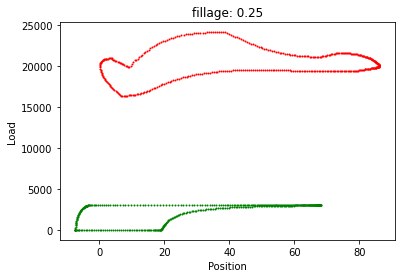

----------------------------------------------
Processing - fillage: 0.3...
Results >>> PPRL: 24042, MPRL: 16116:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


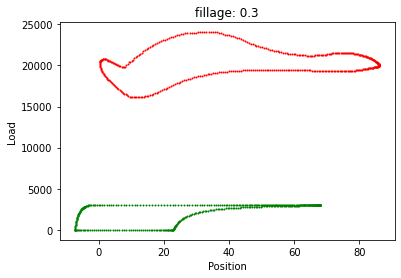

----------------------------------------------
Processing - fillage: 0.35...
Results >>> PPRL: 23875, MPRL: 15843:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


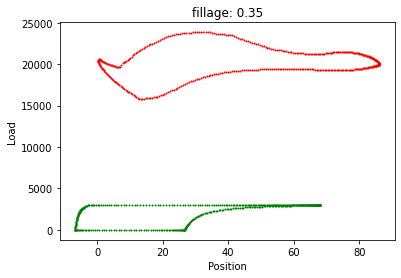

----------------------------------------------
Processing - fillage: 0.4...
Results >>> PPRL: 23727, MPRL: 15575:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


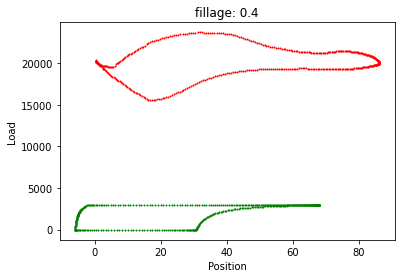

----------------------------------------------
Processing - fillage: 0.45...
Results >>> PPRL: 23613, MPRL: 15381:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


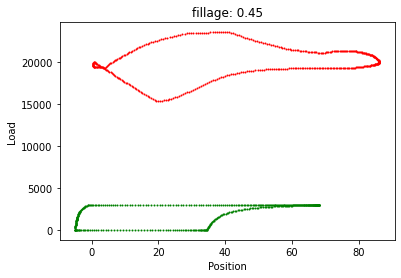

----------------------------------------------
Processing - fillage: 0.5...
Results >>> PPRL: 23651, MPRL: 15239:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


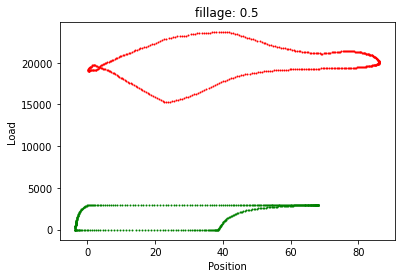

----------------------------------------------
Processing - fillage: 0.55...
Results >>> PPRL: 23663, MPRL: 15203:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


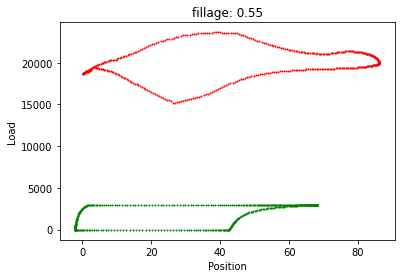

----------------------------------------------
Processing - fillage: 0.6...
Results >>> PPRL: 23585, MPRL: 15205:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


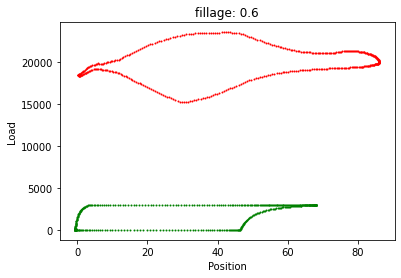

----------------------------------------------
Processing - fillage: 0.65...
Results >>> PPRL: 23702, MPRL: 15157:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


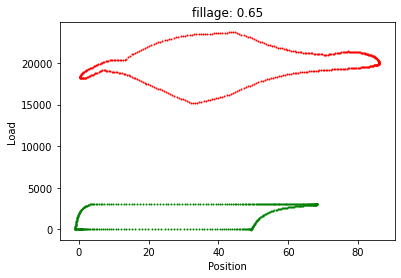

----------------------------------------------
Processing - fillage: 0.7...
Results >>> PPRL: 23746, MPRL: 15133:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


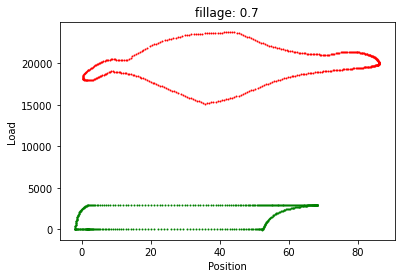

----------------------------------------------
Processing - fillage: 0.75...
Results >>> PPRL: 23794, MPRL: 15090:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


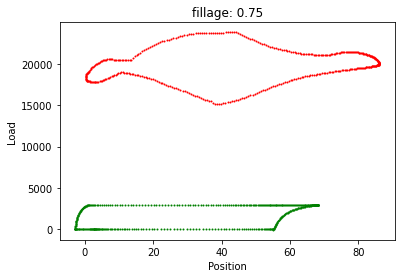

----------------------------------------------
Processing - fillage: 0.8...
Results >>> PPRL: 23835, MPRL: 15060:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


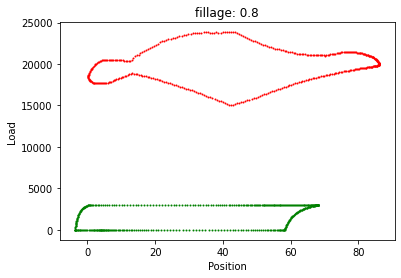

----------------------------------------------
Processing - fillage: 0.85...
Results >>> PPRL: 23849, MPRL: 14974:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


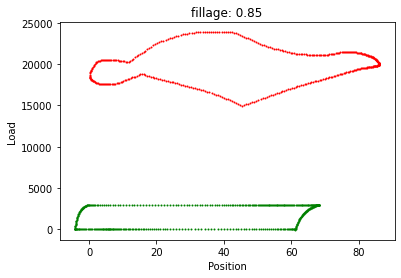

----------------------------------------------
Processing - fillage: 0.9...
Results >>> PPRL: 23865, MPRL: 14962:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


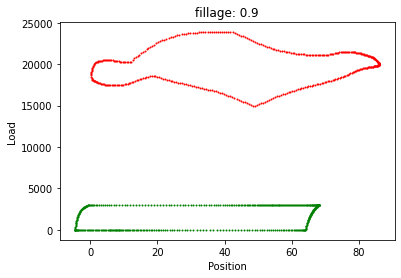

----------------------------------------------
Processing - fillage: 0.95...
Results >>> PPRL: 23885, MPRL: 14913:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


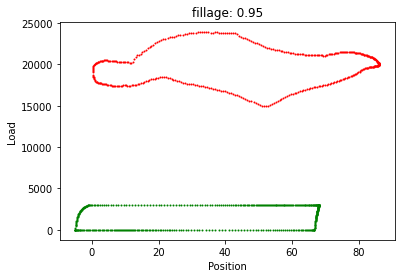

----------------------------------------------
Processing - fillage: 1.0...
Results >>> PPRL: 24489, MPRL: 14822:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


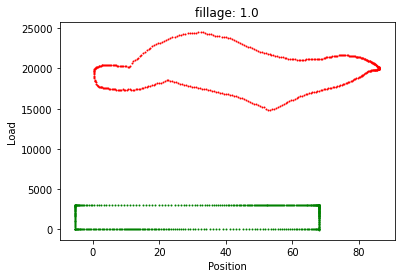

----------------------------------------------
Done processing fillage values.


In [8]:
DoLoop(demo.copy(), "fillage", 0.25, 1.0, 0.05)

***

numpoints 31
Processing - Fo: 3000.0...
Results >>> PPRL: 23794, MPRL: 15090:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


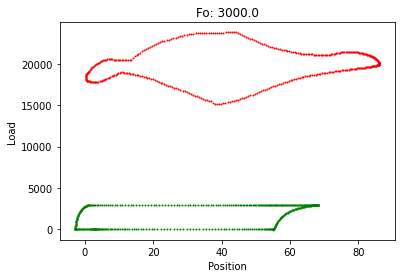

----------------------------------------------
Processing - Fo: 3100.0...
Results >>> PPRL: 23880, MPRL: 15101:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


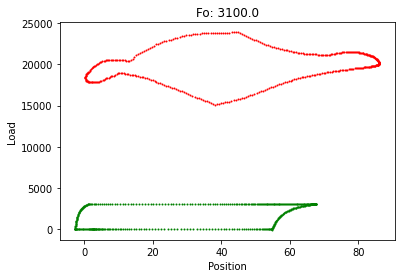

----------------------------------------------
Processing - Fo: 3200.0...
Results >>> PPRL: 23955, MPRL: 15155:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


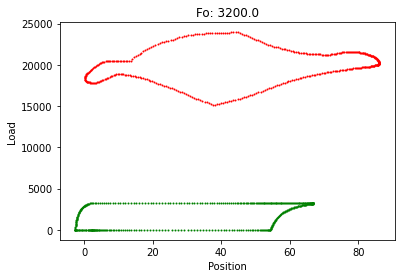

----------------------------------------------
Processing - Fo: 3300.0...
Results >>> PPRL: 24022, MPRL: 15162:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


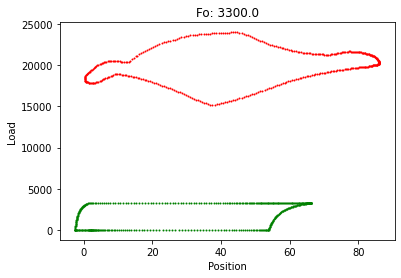

----------------------------------------------
Processing - Fo: 3400.0...
Results >>> PPRL: 24087, MPRL: 15162:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


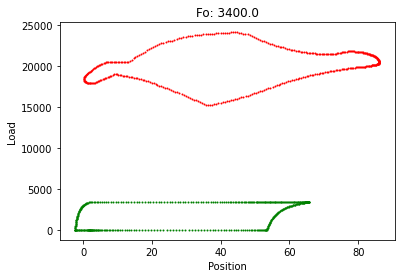

----------------------------------------------
Processing - Fo: 3500.0...
Results >>> PPRL: 24149, MPRL: 15155:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


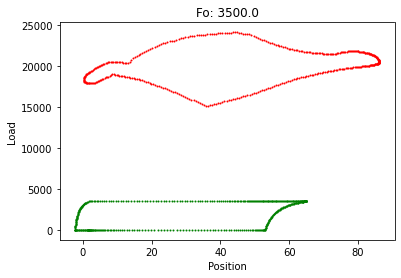

----------------------------------------------
Processing - Fo: 3600.0...
Results >>> PPRL: 24205, MPRL: 15142:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


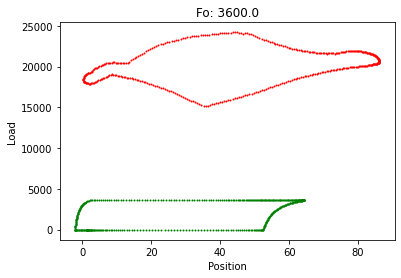

----------------------------------------------
Processing - Fo: 3700.0...
Results >>> PPRL: 24251, MPRL: 15129:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


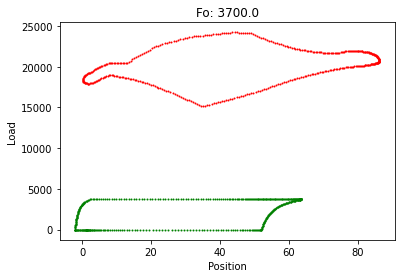

----------------------------------------------
Processing - Fo: 3800.0...
Results >>> PPRL: 24289, MPRL: 15117:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


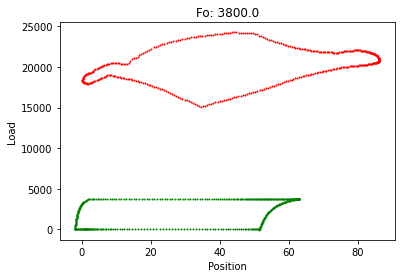

----------------------------------------------
Processing - Fo: 3900.0...
Results >>> PPRL: 24328, MPRL: 15166:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


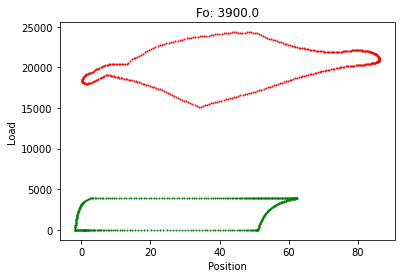

----------------------------------------------
Processing - Fo: 4000.0...
Results >>> PPRL: 24405, MPRL: 15149:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


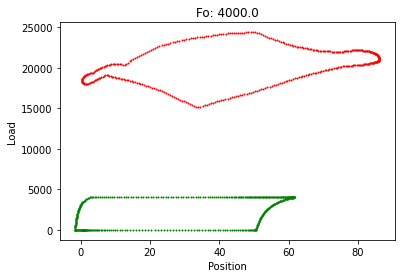

----------------------------------------------
Processing - Fo: 4100.0...
Results >>> PPRL: 24489, MPRL: 15138:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


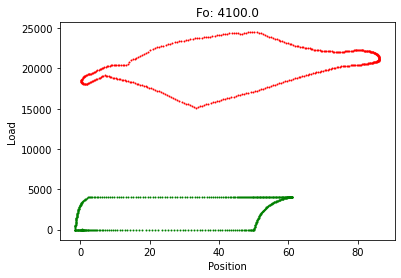

----------------------------------------------
Processing - Fo: 4200.0...
Results >>> PPRL: 24586, MPRL: 15109:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


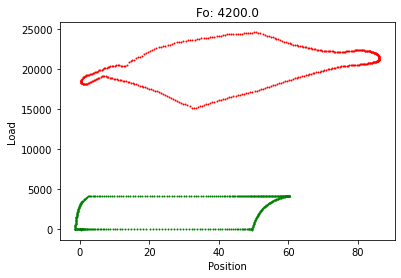

----------------------------------------------
Processing - Fo: 4300.0...
Results >>> PPRL: 24678, MPRL: 15156:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


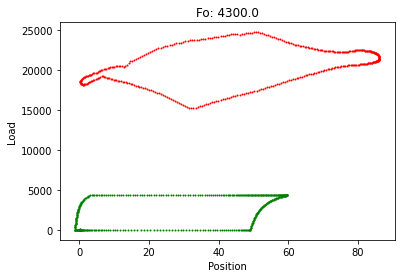

----------------------------------------------
Processing - Fo: 4400.0...
Results >>> PPRL: 24761, MPRL: 15130:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


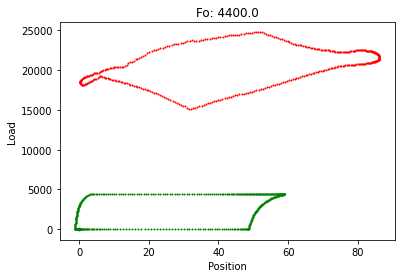

----------------------------------------------
Processing - Fo: 4500.0...
Results >>> PPRL: 24861, MPRL: 15103:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


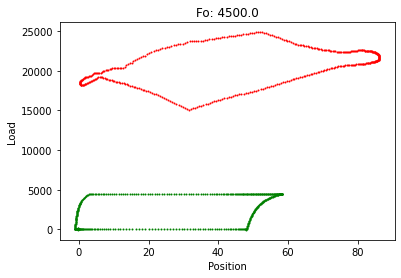

----------------------------------------------
Processing - Fo: 4600.0...
Results >>> PPRL: 24961, MPRL: 15088:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


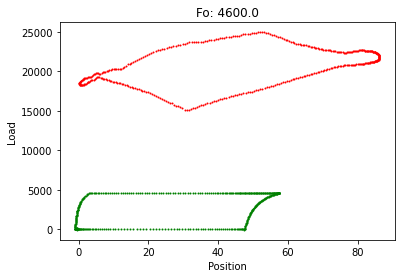

----------------------------------------------
Processing - Fo: 4700.0...
Results >>> PPRL: 25065, MPRL: 15138:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


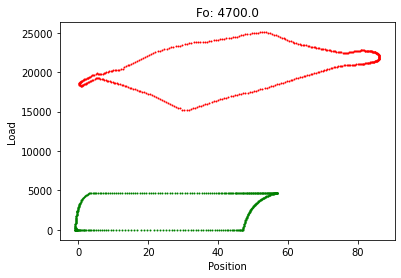

----------------------------------------------
Processing - Fo: 4800.0...
Results >>> PPRL: 25181, MPRL: 15112:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


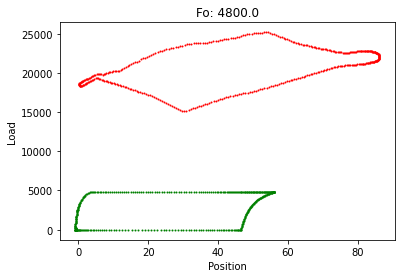

----------------------------------------------
Processing - Fo: 4900.0...
Results >>> PPRL: 25297, MPRL: 15085:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


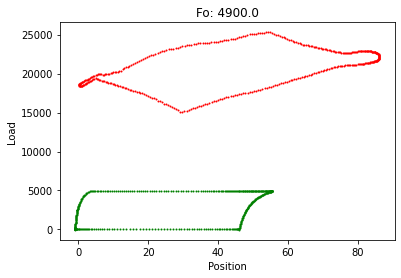

----------------------------------------------
Processing - Fo: 5000.0...
Results >>> PPRL: 25390, MPRL: 15071:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


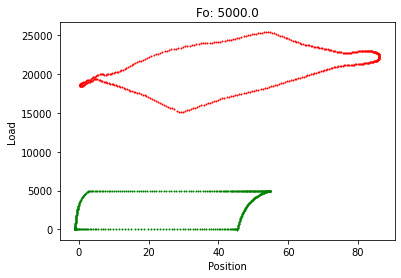

----------------------------------------------
Processing - Fo: 5100.0...
Results >>> PPRL: 25493, MPRL: 15050:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


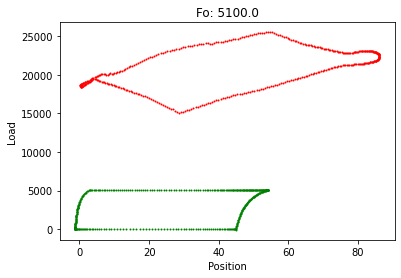

----------------------------------------------
Processing - Fo: 5200.0...
Results >>> PPRL: 25586, MPRL: 15116:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


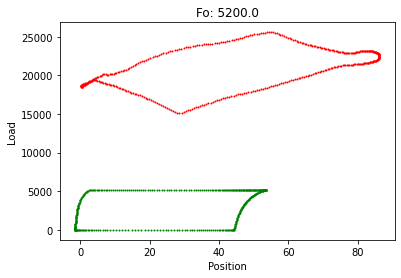

----------------------------------------------
Processing - Fo: 5300.0...
Results >>> PPRL: 25681, MPRL: 15097:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


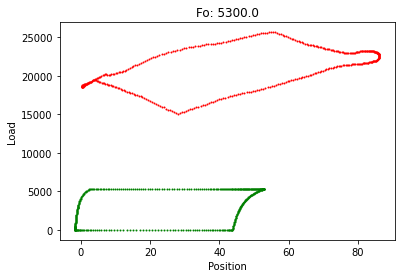

----------------------------------------------
Processing - Fo: 5400.0...
Results >>> PPRL: 25787, MPRL: 15087:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


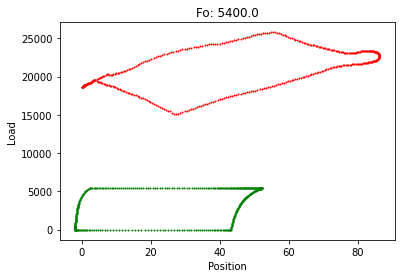

----------------------------------------------
Processing - Fo: 5500.0...
Results >>> PPRL: 25893, MPRL: 15073:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


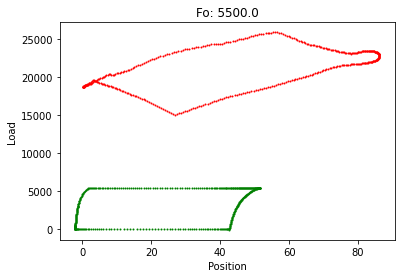

----------------------------------------------
Processing - Fo: 5600.0...
Results >>> PPRL: 25995, MPRL: 15059:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


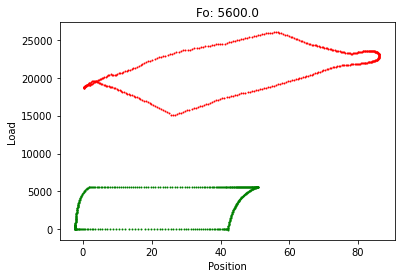

----------------------------------------------
Processing - Fo: 5700.0...
Results >>> PPRL: 26094, MPRL: 15053:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


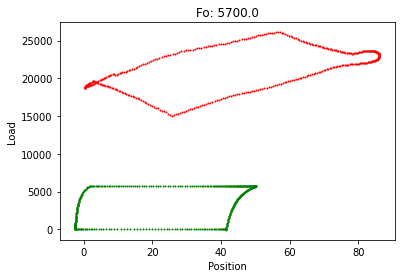

----------------------------------------------
Processing - Fo: 5800.0...
Results >>> PPRL: 26178, MPRL: 15116:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


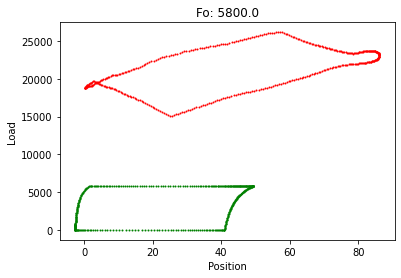

----------------------------------------------
Processing - Fo: 5900.0...
Results >>> PPRL: 26274, MPRL: 15108:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


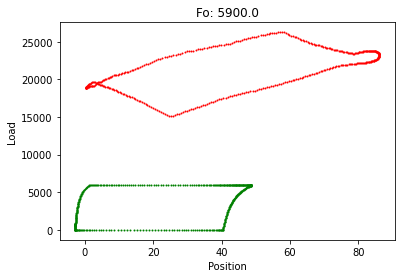

----------------------------------------------
Processing - Fo: 6000.0...
Results >>> PPRL: 26367, MPRL: 15105:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


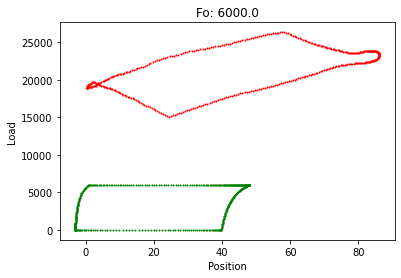

----------------------------------------------
Done processing Fo values.


In [9]:
DoLoop(demo.copy(), "Fo", 3000, 6000, 100)

***

numpoints 26
Processing - SPM: 1.0...
Results >>> PPRL: 21166, MPRL: 17289:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


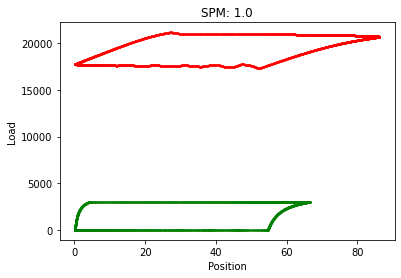

----------------------------------------------
Processing - SPM: 1.2...
Results >>> PPRL: 21261, MPRL: 17196:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


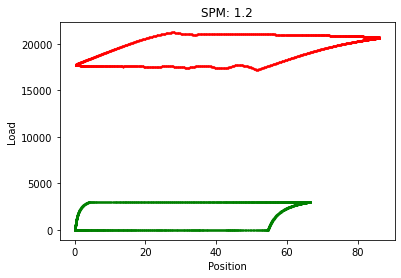

----------------------------------------------
Processing - SPM: 1.4...
Results >>> PPRL: 21357, MPRL: 17115:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


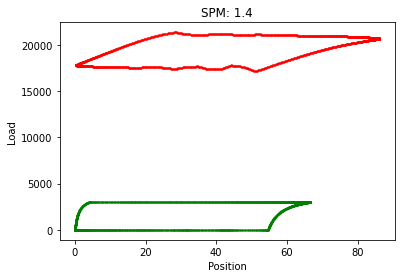

----------------------------------------------
Processing - SPM: 1.6...
Results >>> PPRL: 21452, MPRL: 17044:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


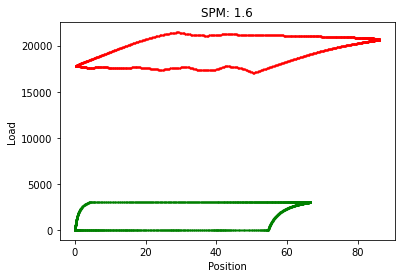

----------------------------------------------
Processing - SPM: 1.8...
Results >>> PPRL: 21548, MPRL: 16953:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


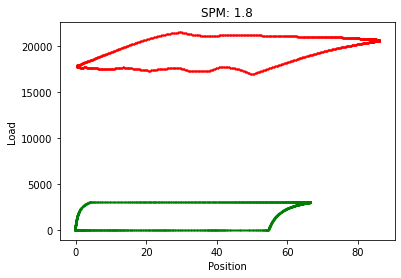

----------------------------------------------
Processing - SPM: 2.0...
Results >>> PPRL: 21642, MPRL: 16875:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


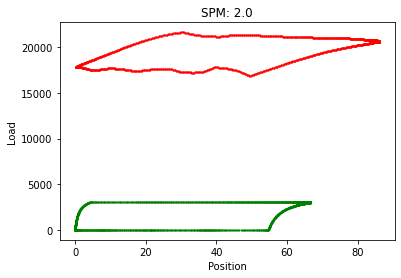

----------------------------------------------
Processing - SPM: 2.2...
Results >>> PPRL: 21740, MPRL: 16776:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


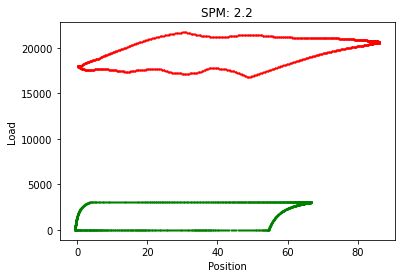

----------------------------------------------
Processing - SPM: 2.4...
Results >>> PPRL: 21832, MPRL: 16691:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


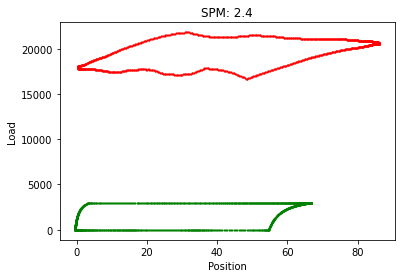

----------------------------------------------
Processing - SPM: 2.6...
Results >>> PPRL: 21917, MPRL: 16617:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


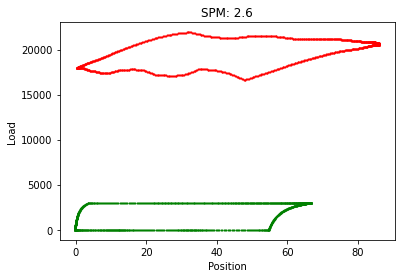

----------------------------------------------
Processing - SPM: 2.8...
Results >>> PPRL: 22027, MPRL: 16548:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


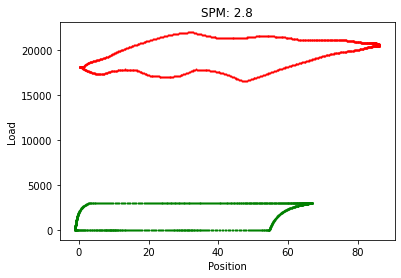

----------------------------------------------
Processing - SPM: 3.0...
Results >>> PPRL: 22111, MPRL: 16446:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


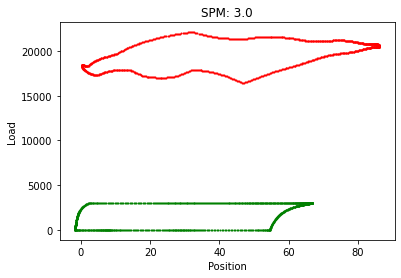

----------------------------------------------
Processing - SPM: 3.2...
Results >>> PPRL: 22180, MPRL: 16353:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


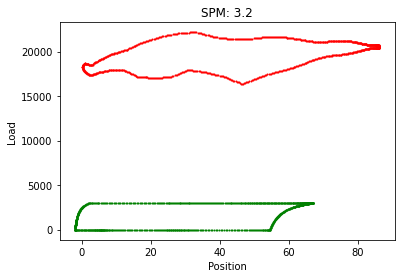

----------------------------------------------
Processing - SPM: 3.4...
Results >>> PPRL: 22329, MPRL: 16296:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


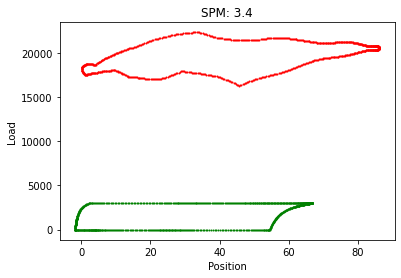

----------------------------------------------
Processing - SPM: 3.6...
Results >>> PPRL: 22392, MPRL: 16258:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


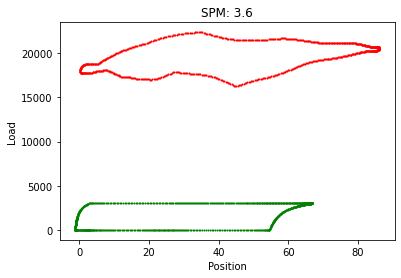

----------------------------------------------
Processing - SPM: 3.8...
Results >>> PPRL: 22452, MPRL: 16172:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


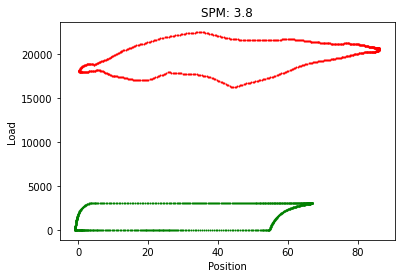

----------------------------------------------
Processing - SPM: 4.0...
Results >>> PPRL: 22517, MPRL: 16076:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


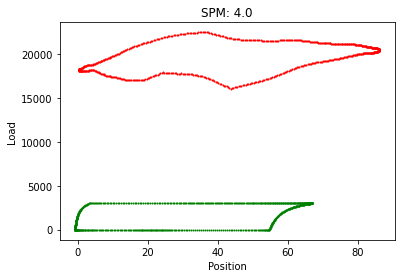

----------------------------------------------
Processing - SPM: 4.2...
Results >>> PPRL: 22638, MPRL: 15983:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


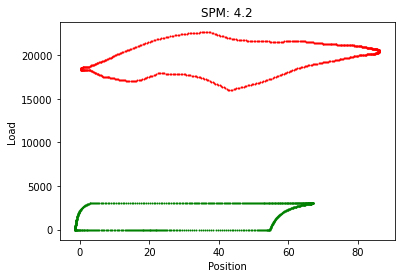

----------------------------------------------
Processing - SPM: 4.4...
Results >>> PPRL: 22733, MPRL: 15901:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


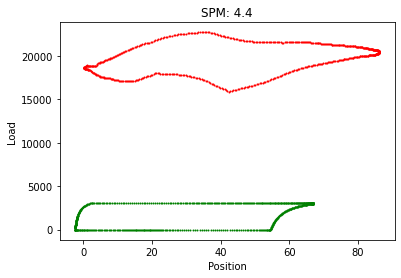

----------------------------------------------
Processing - SPM: 4.6...
Results >>> PPRL: 22831, MPRL: 15830:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


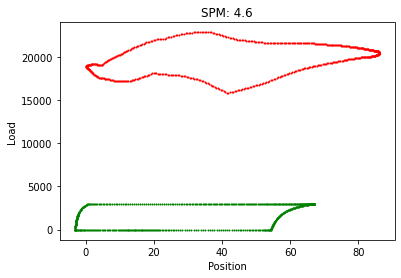

----------------------------------------------
Processing - SPM: 4.8...
Results >>> PPRL: 22955, MPRL: 15742:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


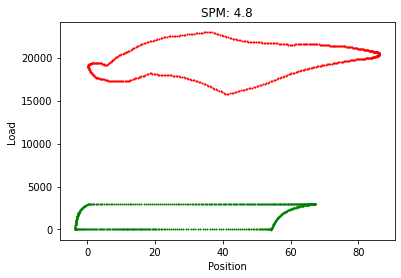

----------------------------------------------
Processing - SPM: 5.0...
Results >>> PPRL: 22951, MPRL: 15674:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


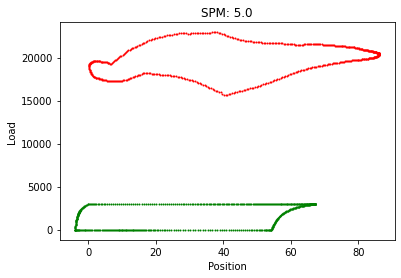

----------------------------------------------
Processing - SPM: 5.2...
Results >>> PPRL: 23103, MPRL: 15631:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


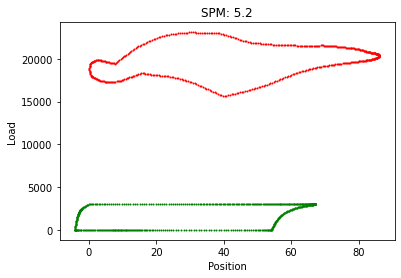

----------------------------------------------
Processing - SPM: 5.4...
Results >>> PPRL: 23330, MPRL: 15527:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


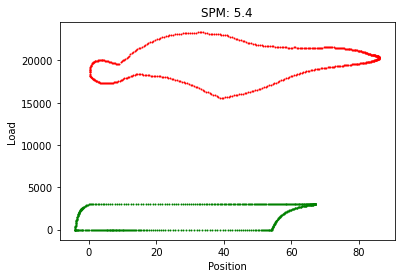

----------------------------------------------
Processing - SPM: 5.6...
Results >>> PPRL: 23492, MPRL: 15454:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


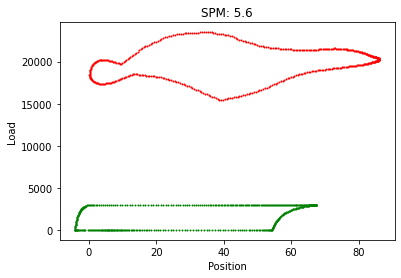

----------------------------------------------
Processing - SPM: 5.8...
Results >>> PPRL: 23616, MPRL: 15321:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


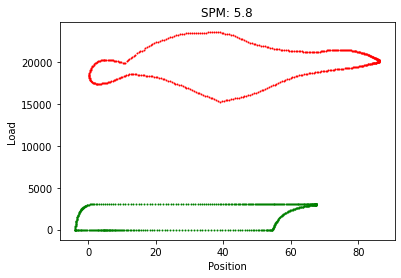

----------------------------------------------
Processing - SPM: 6.0...
Results >>> PPRL: 23700, MPRL: 15232:
UserInfo: {'msg': 'Demo Account. Please contact support. This access may be terminated without notice.'}


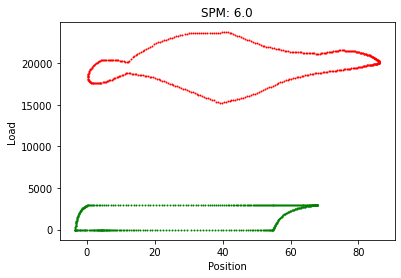

----------------------------------------------
Done processing SPM values.


In [10]:
DoLoop(demo.copy(), "SPM", 1, 6, 0.2)

***